In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorboard.plugins.hparams import api as hp

from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy
from keras.models import Model

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

Using TensorFlow backend.


In [2]:
np.random.seed(0)

tf.config.optimizer.set_jit(True)
scaler = StandardScaler()

### Conjunto de datos: SDSS DR17

In [3]:
data = pd.read_csv('./SDSS/star_classification.csv')
cols = ['alpha','delta','u','g','r','i','z','redshift','class']
data = data[cols]
data.head()

,alpha,delta,u,g,r,i,z,redshift,class
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY


Se cambian las clases a números enteros

$$ \text{GALAXY}: 0,\quad \text{STAR}: 1,\quad \text{QSO}: 2$$

In [4]:
data["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in data["class"]]
print(data.head())
data = data.to_numpy()

        alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   
3  338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454  19.25010   
4  345.282593  21.183866  19.43718  17.58028  16.49747  15.97711  15.54461   

   redshift  class  
0  0.634794      0  
1  0.779136      0  
2  0.644195      0  
3  0.932346      0  
4  0.116123      0  


### Implementación

Se establecen las funciones necesarias para aplicar el algorítmo genético a partir de lo siguiente

- 1) Decodificar el gen del individuo para obtener el núm. de capas ocultas, núm. de neuronas y la tasa de aprendizaje.
    
    
- 2) Preparar el conjunto de datos para dividirlos en conjunto de entrenamiento y validación.
    
    
- 3) Entrenar la red neuronal, calcular la presición del modelo en el conjunto de validación y regresarlo como fitness score para el algorítmo genético.

In [5]:
SC_LAYERS    = np.array([5,10,15,20,25,30,35,40])
SC_NUM_UNITS = np.array([5,10,15,20,25,30,35,40])
SC_LEARNING  = np.array([4,8,12,16,20,24,28,32])*10**(-4)
# SC_BATCHSIZE = np.array([16,32])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max',
                               min_delta=0,
                               patience=6,
                               restore_best_weights=True)]
    
batch_size = 128
epochs = 15

In [6]:
# Divide data into X and Y and implement hot_ones in Y
def prepare_dataset(data):
    X, Y = np.empty((0)), np.empty((0))
    X = data[:,0:8]
    Y = data[:,8]
    Y = to_categorical(Y, num_classes=3)
    return X, Y

In [7]:
# Split dataset into train and validation (70/30)
X,Y = prepare_dataset(data)
X_train, X_test, Y_train, Y_test = split(X, Y, test_size = 0.3, random_state = 0)
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [8]:
def train_evaluate(ga_individual_solution):   
    t = time.time(); t_total = 0
    
    # Decode GA solution to integer for window_size and num_units
    deep_layers_bits = BitArray(ga_individual_solution[0:3])   # 8
    num_units_bits = BitArray(ga_individual_solution[3:6])     # 8
    learning_rate_bits = BitArray(ga_individual_solution[6:9]) # 8
#     batch_size_bits = BitArray(ga_individual_solution[6:7]) # 2
    
    deep_layers = SC_LAYERS[deep_layers_bits.uint]
    num_units = SC_NUM_UNITS[num_units_bits.uint]
    learning_rate = SC_LEARNING[learning_rate_bits.uint]
#     batch_size = SC_BATCHSIZE[batch_size_bits.uint]
    
    print('\n--- Starting trial:', len(datos) )
    print('Deep layers: ',deep_layers,', Num of Units: ',num_units,', Learning rate: ',learning_rate)
    
    # Train model and predict on validation set
    model = keras.Sequential()
    model.add(Input(shape=(int(X_train.shape[1]),)))
    model.add(Dense(num_units, input_shape=(int(X_train.shape[1]),)))
    
    for i in range(deep_layers):        
        model.add(Dense(num_units, activation='relu'))
    model.add(Dense(3, activation=tf.nn.softmax))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=["categorical_accuracy"])
    model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test),
              callbacks=callbacks, batch_size=batch_size, shuffle=True, verbose=0)
    
    _, score = model.evaluate(X_test, Y_test)    
    t = time.time()-t
    print("Accuracy:", score, "Tiempo de cómputo:", t)

    datos.append([deep_layers, num_units, learning_rate, score, t])
    
    return score,

A continuación, use la paquetería DEAP para definir las cosas para ejecutar GA. Usaremos una representación binaria para la solución de longitud diez. Se inicializará aleatoriamente utilizando la distribución de Bernoulli. Del mismo modo, se utiliza el crossover ordenado, la mutación aleatoria y la selección de la rueda de la ruleta. Los valores del parámetro GA se inicializan arbitrariamente; Te sugerimos que juegues con diferentes configuraciones.



In [9]:
population_size = 10
num_generations = 10
gene_length = 9

datos = []

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = [1.0])
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.5, mutpb = 0.2, 
                        ngen = num_generations, verbose = 1)


--- Starting trial: 0
Deep layers:  40 , Num of Units:  30 , Learning rate:  0.0016
Train on 70000 samples, validate on 30000 samples
Epoch 1/15
70000/70000 [==============================] - 22s 313us/sample - loss: 0.9628 - categorical_accuracy: 0.5948 - val_loss: 0.9565 - val_categorical_accuracy: 0.5936
Epoch 2/15
70000/70000 [==============================] - 13s 181us/sample - loss: 0.9558 - categorical_accuracy: 0.5948 - val_loss: 0.9565 - val_categorical_accuracy: 0.5936
Epoch 3/15
70000/70000 [==============================] - 14s 205us/sample - loss: 0.9556 - categorical_accuracy: 0.5948 - val_loss: 0.9561 - val_categorical_accuracy: 0.5936
Epoch 4/15
70000/70000 [==============================] - 15s 212us/sample - loss: 0.9556 - categorical_accuracy: 0.5948 - val_loss: 0.9569 - val_categorical_accuracy: 0.5936
Epoch 5/15
70000/70000 [==============================] - 12s 176us/sample - loss: 0.9557 - categorical_accuracy: 0.5948 - val_loss: 0.9566 - val_categorical_accurac

70000/70000 [==============================] - 11s 162us/sample - loss: 0.9555 - categorical_accuracy: 0.5948 - val_loss: 0.9569 - val_categorical_accuracy: 0.5936
Epoch 5/15
70000/70000 [==============================] - 10s 143us/sample - loss: 0.9558 - categorical_accuracy: 0.5948 - val_loss: 0.9564 - val_categorical_accuracy: 0.5936
Epoch 6/15
70000/70000 [==============================] - 11s 158us/sample - loss: 0.9556 - categorical_accuracy: 0.5948 - val_loss: 0.9561 - val_categorical_accuracy: 0.5936
Epoch 7/15
30000/30000 [==============================] - 6s 209us/sample - loss: 0.9561 - categorical_accuracy: 0.5936
Accuracy: 0.59363335 Tiempo de cómputo: 94.46412563323975

--- Starting trial: 4
Deep layers:  40 , Num of Units:  25 , Learning rate:  0.0024000000000000002
Train on 70000 samples, validate on 30000 samples
Epoch 1/15
70000/70000 [==============================] - 26s 370us/sample - loss: 0.9609 - categorical_accuracy: 0.5948 - val_loss: 0.9565 - val_categorical_

Epoch 5/15
70000/70000 [==============================] - 6s 83us/sample - loss: 0.1204 - categorical_accuracy: 0.9622 - val_loss: 0.5647 - val_categorical_accuracy: 0.9638
Epoch 6/15
70000/70000 [==============================] - 5s 74us/sample - loss: 0.1170 - categorical_accuracy: 0.9634 - val_loss: 0.5050 - val_categorical_accuracy: 0.9675
Epoch 7/15
70000/70000 [==============================] - 5s 78us/sample - loss: 0.1136 - categorical_accuracy: 0.9651 - val_loss: 0.4941 - val_categorical_accuracy: 0.9647
Epoch 8/15
70000/70000 [==============================] - 8s 121us/sample - loss: 0.1105 - categorical_accuracy: 0.9665 - val_loss: 0.4810 - val_categorical_accuracy: 0.9653
Epoch 9/15
70000/70000 [==============================] - 8s 107us/sample - loss: 0.1114 - categorical_accuracy: 0.9655 - val_loss: 0.3896 - val_categorical_accuracy: 0.9525
Epoch 10/15
70000/70000 [==============================] - 6s 83us/sample - loss: 0.1074 - categorical_accuracy: 0.9668 - val_loss: 0

70000/70000 [==============================] - 14s 201us/sample - loss: 0.2085 - categorical_accuracy: 0.9339 - val_loss: 1.0155 - val_categorical_accuracy: 0.9357
Epoch 9/15
70000/70000 [==============================] - 14s 198us/sample - loss: 0.2417 - categorical_accuracy: 0.9190 - val_loss: 0.7704 - val_categorical_accuracy: 0.9460
Epoch 10/15
70000/70000 [==============================] - 14s 194us/sample - loss: 0.2019 - categorical_accuracy: 0.9396 - val_loss: 1.4504 - val_categorical_accuracy: 0.9020
Epoch 11/15
70000/70000 [==============================] - 14s 193us/sample - loss: 0.1820 - categorical_accuracy: 0.9453 - val_loss: 3.1028 - val_categorical_accuracy: 0.9602
Epoch 12/15
70000/70000 [==============================] - 12s 173us/sample - loss: 0.2001 - categorical_accuracy: 0.9334 - val_loss: 0.8534 - val_categorical_accuracy: 0.9442
Epoch 13/15
70000/70000 [==============================] - 14s 194us/sample - loss: 0.1745 - categorical_accuracy: 0.9464 - val_loss:

Epoch 5/15
70000/70000 [==============================] - 6s 84us/sample - loss: 0.1186 - categorical_accuracy: 0.9632 - val_loss: 0.2795 - val_categorical_accuracy: 0.9640
Epoch 6/15
70000/70000 [==============================] - 6s 81us/sample - loss: 0.1133 - categorical_accuracy: 0.9658 - val_loss: 0.3442 - val_categorical_accuracy: 0.9660
Epoch 7/15
70000/70000 [==============================] - 6s 82us/sample - loss: 0.1145 - categorical_accuracy: 0.9652 - val_loss: 0.3240 - val_categorical_accuracy: 0.9652
Epoch 8/15
70000/70000 [==============================] - 6s 82us/sample - loss: 0.1099 - categorical_accuracy: 0.9663 - val_loss: 0.3542 - val_categorical_accuracy: 0.9684
Epoch 9/15
70000/70000 [==============================] - 6s 83us/sample - loss: 0.1089 - categorical_accuracy: 0.9667 - val_loss: 0.5154 - val_categorical_accuracy: 0.9568
Epoch 10/15
70000/70000 [==============================] - 6s 80us/sample - loss: 0.1071 - categorical_accuracy: 0.9671 - val_loss: 0.6

70000/70000 [==============================] - 8s 115us/sample - loss: 0.1104 - categorical_accuracy: 0.9658 - val_loss: 0.1022 - val_categorical_accuracy: 0.9690
Epoch 10/15
70000/70000 [==============================] - 8s 113us/sample - loss: 0.1166 - categorical_accuracy: 0.9641 - val_loss: 0.1051 - val_categorical_accuracy: 0.9691
Epoch 11/15
70000/70000 [==============================] - 8s 114us/sample - loss: 0.1064 - categorical_accuracy: 0.9681 - val_loss: 0.1082 - val_categorical_accuracy: 0.9662
Epoch 12/15
70000/70000 [==============================] - 8s 113us/sample - loss: 0.1069 - categorical_accuracy: 0.9676 - val_loss: 0.1049 - val_categorical_accuracy: 0.9691
Epoch 13/15
70000/70000 [==============================] - 8s 117us/sample - loss: 0.1089 - categorical_accuracy: 0.9670 - val_loss: 0.1056 - val_categorical_accuracy: 0.9693
Epoch 14/15
70000/70000 [==============================] - 8s 114us/sample - loss: 0.1085 - categorical_accuracy: 0.9672 - val_loss: 0.12

70000/70000 [==============================] - 5s 65us/sample - loss: 0.1955 - categorical_accuracy: 0.9553 - val_loss: 1.9259 - val_categorical_accuracy: 0.9589
Epoch 6/15
70000/70000 [==============================] - 4s 64us/sample - loss: 0.1705 - categorical_accuracy: 0.9576 - val_loss: 1.6580 - val_categorical_accuracy: 0.9579
Epoch 7/15
70000/70000 [==============================] - 4s 62us/sample - loss: 0.1546 - categorical_accuracy: 0.9588 - val_loss: 1.5182 - val_categorical_accuracy: 0.9617
Epoch 8/15
70000/70000 [==============================] - 5s 73us/sample - loss: 0.1425 - categorical_accuracy: 0.9619 - val_loss: 1.3357 - val_categorical_accuracy: 0.9638
Epoch 9/15
70000/70000 [==============================] - 5s 70us/sample - loss: 0.1383 - categorical_accuracy: 0.9615 - val_loss: 1.1070 - val_categorical_accuracy: 0.9627
Epoch 10/15
70000/70000 [==============================] - 5s 75us/sample - loss: 0.1311 - categorical_accuracy: 0.9634 - val_loss: 0.8865 - val_c

Epoch 2/15
70000/70000 [==============================] - 18s 254us/sample - loss: 0.9577 - categorical_accuracy: 0.5946 - val_loss: 0.9574 - val_categorical_accuracy: 0.5936
Epoch 3/15
70000/70000 [==============================] - 16s 231us/sample - loss: 0.4602 - categorical_accuracy: 0.8163 - val_loss: 0.8501 - val_categorical_accuracy: 0.9450
Epoch 4/15
70000/70000 [==============================] - 15s 210us/sample - loss: 0.2219 - categorical_accuracy: 0.9277 - val_loss: 1.0997 - val_categorical_accuracy: 0.9548
Epoch 5/15
70000/70000 [==============================] - 18s 255us/sample - loss: 0.2108 - categorical_accuracy: 0.9295 - val_loss: 0.3336 - val_categorical_accuracy: 0.9311
Epoch 6/15
70000/70000 [==============================] - 18s 256us/sample - loss: 0.2289 - categorical_accuracy: 0.9245 - val_loss: 0.5418 - val_categorical_accuracy: 0.8971
Epoch 7/15
70000/70000 [==============================] - 19s 273us/sample - loss: 0.2805 - categorical_accuracy: 0.9079 - va

70000/70000 [==============================] - 4s 52us/sample - loss: 0.1150 - categorical_accuracy: 0.9660 - val_loss: 0.2937 - val_categorical_accuracy: 0.9674
Epoch 13/15
70000/70000 [==============================] - 4s 51us/sample - loss: 0.1178 - categorical_accuracy: 0.9649 - val_loss: 0.3267 - val_categorical_accuracy: 0.9681
Epoch 14/15
70000/70000 [==============================] - 3s 50us/sample - loss: 0.1123 - categorical_accuracy: 0.9673 - val_loss: 0.3342 - val_categorical_accuracy: 0.9681
Epoch 15/15
30000/30000 [==============================] - 3s 88us/sample - loss: 0.3141 - categorical_accuracy: 0.9640
Accuracy: 0.9640333 Tiempo de cómputo: 61.78805756568909

--- Starting trial: 26
Deep layers:  25 , Num of Units:  40 , Learning rate:  0.002
Train on 70000 samples, validate on 30000 samples
Epoch 1/15
70000/70000 [==============================] - 20s 279us/sample - loss: 0.5113 - categorical_accuracy: 0.8006 - val_loss: 0.3980 - val_categorical_accuracy: 0.9302
Epo

70000/70000 [==============================] - 5s 75us/sample - loss: 0.4494 - categorical_accuracy: 0.8314 - val_loss: 0.4557 - val_categorical_accuracy: 0.8365
Epoch 9/15
70000/70000 [==============================] - 5s 71us/sample - loss: 0.4347 - categorical_accuracy: 0.8405 - val_loss: 0.4261 - val_categorical_accuracy: 0.8445
Epoch 10/15
70000/70000 [==============================] - 5s 73us/sample - loss: 0.4210 - categorical_accuracy: 0.8513 - val_loss: 0.4208 - val_categorical_accuracy: 0.8394
Epoch 11/15
70000/70000 [==============================] - 5s 68us/sample - loss: 0.4119 - categorical_accuracy: 0.8589 - val_loss: 0.4089 - val_categorical_accuracy: 0.8647
Epoch 12/15
70000/70000 [==============================] - 6s 81us/sample - loss: 0.4043 - categorical_accuracy: 0.8657 - val_loss: 0.4000 - val_categorical_accuracy: 0.8676
Epoch 13/15
70000/70000 [==============================] - 5s 78us/sample - loss: 0.3957 - categorical_accuracy: 0.8699 - val_loss: 0.3942 - va

70000/70000 [==============================] - 6s 88us/sample - loss: 0.1068 - categorical_accuracy: 0.9670 - val_loss: 0.2786 - val_categorical_accuracy: 0.9664
Epoch 13/15
70000/70000 [==============================] - 7s 94us/sample - loss: 0.1084 - categorical_accuracy: 0.9668 - val_loss: 0.4448 - val_categorical_accuracy: 0.9693
Epoch 14/15
70000/70000 [==============================] - 4s 61us/sample - loss: 0.1031 - categorical_accuracy: 0.9685 - val_loss: 0.1019 - val_categorical_accuracy: 0.9693
Epoch 15/15
30000/30000 [==============================] - 3s 110us/sample - loss: 0.2571 - categorical_accuracy: 0.9676
Accuracy: 0.96756667 Tiempo de cómputo: 96.04415273666382

--- Starting trial: 32
Deep layers:  10 , Num of Units:  15 , Learning rate:  0.0008
Train on 70000 samples, validate on 30000 samples
Epoch 1/15
70000/70000 [==============================] - 11s 158us/sample - loss: 0.6100 - categorical_accuracy: 0.7448 - val_loss: 0.3335 - val_categorical_accuracy: 0.8787


Train on 70000 samples, validate on 30000 samples
Epoch 1/15
70000/70000 [==============================] - 23s 329us/sample - loss: 0.9738 - categorical_accuracy: 0.5941 - val_loss: 0.9561 - val_categorical_accuracy: 0.5936
Epoch 2/15
70000/70000 [==============================] - 11s 164us/sample - loss: 0.9555 - categorical_accuracy: 0.5948 - val_loss: 0.9562 - val_categorical_accuracy: 0.5936
Epoch 3/15
70000/70000 [==============================] - 11s 163us/sample - loss: 0.9554 - categorical_accuracy: 0.5948 - val_loss: 0.9542 - val_categorical_accuracy: 0.5936
Epoch 4/15
70000/70000 [==============================] - 11s 164us/sample - loss: 0.7153 - categorical_accuracy: 0.7074 - val_loss: 0.5978 - val_categorical_accuracy: 0.7518
Epoch 5/15
70000/70000 [==============================] - 9s 133us/sample - loss: 0.3437 - categorical_accuracy: 0.8776 - val_loss: 0.2043 - val_categorical_accuracy: 0.9421
Epoch 6/15
70000/70000 [==============================] - 11s 158us/sample -

Epoch 6/15
70000/70000 [==============================] - 12s 171us/sample - loss: 0.9554 - categorical_accuracy: 0.5948 - val_loss: 0.9561 - val_categorical_accuracy: 0.5936- l - ETA: 0s - loss: 0.9555 - catego
Epoch 7/15
30000/30000 [==============================] - 6s 200us/sample - loss: 0.9561 - categorical_accuracy: 0.5936
Accuracy: 0.59363335 Tiempo de cómputo: 108.91603326797485

--- Starting trial: 39
Deep layers:  20 , Num of Units:  40 , Learning rate:  0.0008
Train on 70000 samples, validate on 30000 samples
Epoch 1/15
70000/70000 [==============================] - 18s 264us/sample - loss: 0.6574 - categorical_accuracy: 0.7393 - val_loss: 0.2355 - val_categorical_accuracy: 0.9363
Epoch 2/15
70000/70000 [==============================] - 9s 134us/sample - loss: 0.2001 - categorical_accuracy: 0.9392 - val_loss: 0.2016 - val_categorical_accuracy: 0.9492
Epoch 3/15
70000/70000 [==============================] - 9s 131us/sample - loss: 0.1480 - categorical_accuracy: 0.9548 - va

70000/70000 [==============================] - 13s 181us/sample - loss: 0.1482 - categorical_accuracy: 0.9542 - val_loss: 0.1470 - val_categorical_accuracy: 0.9551
Epoch 11/15
70000/70000 [==============================] - 13s 179us/sample - loss: 0.1431 - categorical_accuracy: 0.9571 - val_loss: 0.1439 - val_categorical_accuracy: 0.9598
Epoch 12/15
70000/70000 [==============================] - 12s 178us/sample - loss: 0.1383 - categorical_accuracy: 0.9590 - val_loss: 0.1407 - val_categorical_accuracy: 0.9601
Epoch 13/15
70000/70000 [==============================] - 13s 185us/sample - loss: 0.1731 - categorical_accuracy: 0.9454 - val_loss: 0.2525 - val_categorical_accuracy: 0.9307
Epoch 14/15
70000/70000 [==============================] - 11s 153us/sample - loss: 0.1995 - categorical_accuracy: 0.9367 - val_loss: 0.2164 - val_categorical_accuracy: 0.9168A: 1s -
Epoch 15/15
30000/30000 [==============================] - 6s 215us/sample - loss: 0.1598 - categorical_accuracy: 0.9523
Accu

Epoch 9/15
70000/70000 [==============================] - 4s 63us/sample - loss: 0.1150 - categorical_accuracy: 0.9652 - val_loss: 0.1778 - val_categorical_accuracy: 0.9549
Epoch 10/15
70000/70000 [==============================] - 4s 64us/sample - loss: 0.1160 - categorical_accuracy: 0.9652 - val_loss: 0.1618 - val_categorical_accuracy: 0.9657
Epoch 11/15
70000/70000 [==============================] - 5s 75us/sample - loss: 0.1118 - categorical_accuracy: 0.9666 - val_loss: 0.1825 - val_categorical_accuracy: 0.9620
Epoch 12/15
70000/70000 [==============================] - 5s 72us/sample - loss: 0.1113 - categorical_accuracy: 0.9663 - val_loss: 0.1651 - val_categorical_accuracy: 0.9649
Epoch 13/15
70000/70000 [==============================] - 6s 81us/sample - loss: 0.1095 - categorical_accuracy: 0.9675 - val_loss: 0.1727 - val_categorical_accuracy: 0.9656
Epoch 14/15
30000/30000 [==============================] - 3s 115us/sample - loss: 0.1429 - categorical_accuracy: 0.9679
Accuracy: 

### Guardar datos

In [10]:
filename = "historial_sdss.txt"
df = pd.DataFrame(datos, columns = ["Deep size", "Num units", "Learning rate", "Accuracy", "Tiempo de ejecución"])

df.sort_values(by=["Accuracy", "Tiempo de ejecución"], ascending=[0,0], ignore_index=True, inplace=True)

df.to_csv(filename, header=True, index=False, sep='\t', mode='w') # a=append, w=overwrite

In [11]:
df

,Deep size,Num units,Learning rate,Accuracy,Tiempo de ejecución
0,20,40,0.0008,0.970867,153.535004
1,20,25,0.0008,0.970633,162.363049
2,35,25,0.0024,0.970167,233.924334
3,10,30,0.0012,0.969633,110.836161
4,20,40,0.0008,0.969567,145.803060
5,10,25,0.0020,0.969267,96.513949
6,10,30,0.0016,0.969233,93.951861
7,5,30,0.0012,0.968733,73.867024
8,20,35,0.0008,0.968433,170.746890
9,10,20,0.0008,0.968233,87.122006


In [12]:
np.sum(df[["Tiempo de ejecución"]])/60/60

Tiempo de ejecución    1.728621
dtype: float64

### Cargar datos

In [13]:
pathname = os.path.join('.\\', filename)
while True:
    try: 
        df 
        break
    except:
        df = pd.read_csv(pathname, delimiter = "\t")
        break

In [14]:
df

,Deep size,Num units,Learning rate,Accuracy,Tiempo de ejecución
0,20,40,0.0008,0.970867,153.535004
1,20,25,0.0008,0.970633,162.363049
2,35,25,0.0024,0.970167,233.924334
3,10,30,0.0012,0.969633,110.836161
4,20,40,0.0008,0.969567,145.803060
5,10,25,0.0020,0.969267,96.513949
6,10,30,0.0016,0.969233,93.951861
7,5,30,0.0012,0.968733,73.867024
8,20,35,0.0008,0.968433,170.746890
9,10,20,0.0008,0.968233,87.122006


### Mejores individuos

In [19]:
# Selecciona los mejores k individuos - (para k=5)
k = 5
best_genes = df.iloc[:k,]

best_deep_size = best_genes.iloc[:,0]
best_num_units = best_genes.iloc[:,1]
best_learning_rate = best_genes.iloc[:,2]

best_genes

,Deep size,Num units,Learning rate,Accuracy,Tiempo de ejecución
0,20,40,0.0008,0.970867,153.535004
1,20,25,0.0008,0.970633,162.363049
2,35,25,0.0024,0.970167,233.924334
3,10,30,0.0012,0.969633,110.836161
4,20,40,0.0008,0.969567,145.803060


In [20]:
best_deep_size

0    20
1    20
2    35
3    10
4    20
Name: Deep size, dtype: int64

In [28]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set

X,Y = prepare_dataset(data)
X_train, X_test, Y_train, Y_test = split(X, Y, test_size = 0.20, random_state = 0)

models = []
historial = []
y_pred = []

for k in range(len(best_deep_size)):
    print('\n--- Starting trial:', k)
    print('Deep Size: ', best_deep_size[k], ', Num of Units: ', best_num_units[k], ', Learning rate: ', best_learning_rate[k])
    
    models.append(keras.Sequential())
    models[-1].add(Input(shape=(int(X_train.shape[1]),)))
    models[-1].add(Dense(best_num_units[k], input_shape=(int(X_train.shape[1]),)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)

    for i in range(best_deep_size[k]):        
        models[-1].add(Dense(best_num_units[k], activation='relu'))
    models[-1].add(Dense(3, activation=tf.nn.softmax))

    optimizer = keras.optimizers.Adam(learning_rate=best_learning_rate[k], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    models[-1].compile(
            optimizer=optimizer,
            loss=CategoricalCrossentropy(),
            metrics=["categorical_accuracy"])
            
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                       min_delta=0,
                                       patience=50,
                                       restore_best_weights=True)]
#     history = models[-1].fit(X_train, y_train, validation_data=(X_test, y_test), 
#                         epochs=best_epochs, callbacks=callbacks, batch_size=best_batch_size, shuffle=True)
    historial.append(models[-1].fit(X_train, y_train, epochs=20, validation_data=(X_test, Y_test),
                                    batch_size=128, shuffle=True))
    y_pred.append(models[-1].predict(X))
    
    _, score = models[-1].evaluate(X_test, Y_test)  

    print('Test score: ', score)


--- Starting trial: 0
Deep Size:  20 , Num of Units:  40 , Learning rate:  0.0008
Train on 80000 samples, validate on 20000 samples
Epoch 1/20
80000/80000 [==============================] - 17s 215us/sample - loss: 0.9501 - categorical_accuracy: 0.5922 - val_loss: 0.9419 - val_categorical_accuracy: 0.5925
Epoch 2/20
80000/80000 [==============================] - 10s 124us/sample - loss: 0.6575 - categorical_accuracy: 0.7178 - val_loss: 0.5942 - val_categorical_accuracy: 0.7368
Epoch 3/20
80000/80000 [==============================] - 10s 126us/sample - loss: 0.5502 - categorical_accuracy: 0.7659 - val_loss: 0.5578 - val_categorical_accuracy: 0.7521
Epoch 4/20
80000/80000 [==============================] - 10s 129us/sample - loss: 0.5114 - categorical_accuracy: 0.7856 - val_loss: 0.5584 - val_categorical_accuracy: 0.7725
Epoch 5/20
80000/80000 [==============================] - 10s 129us/sample - loss: 0.4350 - categorical_accuracy: 0.8206 - val_loss: 0.3202 - val_categorical_accuracy:

80000/80000 [==============================] - 13s 160us/sample - loss: 0.9554 - categorical_accuracy: 0.5949 - val_loss: 0.9579 - val_categorical_accuracy: 0.5925
Epoch 4/20
80000/80000 [==============================] - 13s 159us/sample - loss: 0.9553 - categorical_accuracy: 0.5949 - val_loss: 0.9575 - val_categorical_accuracy: 0.5925
Epoch 5/20
80000/80000 [==============================] - 13s 162us/sample - loss: 0.9552 - categorical_accuracy: 0.5949 - val_loss: 0.9583 - val_categorical_accuracy: 0.5925
Epoch 6/20
80000/80000 [==============================] - 13s 161us/sample - loss: 0.9553 - categorical_accuracy: 0.5949 - val_loss: 0.9579 - val_categorical_accuracy: 0.5925
Epoch 7/20
80000/80000 [==============================] - 13s 163us/sample - loss: 0.9552 - categorical_accuracy: 0.5949 - val_loss: 0.9596 - val_categorical_accuracy: 0.5925
Epoch 8/20
80000/80000 [==============================] - 13s 159us/sample - loss: 0.9552 - categorical_accuracy: 0.5949 - val_loss: 0.9

Epoch 7/20
80000/80000 [==============================] - 10s 120us/sample - loss: 0.2601 - categorical_accuracy: 0.9028 - val_loss: 0.2273 - val_categorical_accuracy: 0.9154
Epoch 8/20
80000/80000 [==============================] - 9s 109us/sample - loss: 0.2249 - categorical_accuracy: 0.9194 - val_loss: 0.1841 - val_categorical_accuracy: 0.9327
Epoch 9/20
80000/80000 [==============================] - 9s 108us/sample - loss: 0.2096 - categorical_accuracy: 0.9259 - val_loss: 0.1735 - val_categorical_accuracy: 0.9410
Epoch 10/20
80000/80000 [==============================] - 10s 124us/sample - loss: 0.2261 - categorical_accuracy: 0.9176 - val_loss: 0.2017 - val_categorical_accuracy: 0.9307
Epoch 11/20
80000/80000 [==============================] - 9s 118us/sample - loss: 0.2096 - categorical_accuracy: 0.9258 - val_loss: 0.1907 - val_categorical_accuracy: 0.9295
Epoch 12/20
80000/80000 [==============================] - 9s 110us/sample - loss: 0.2112 - categorical_accuracy: 0.9254 - val

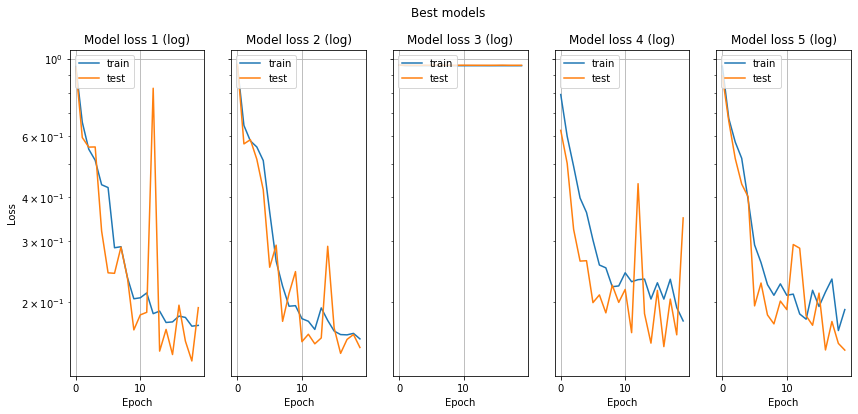

In [31]:
fig, axs = plt.subplots(1, len(models), figsize=(14,6), sharey='row')
fig.suptitle('Best models')
titles = []
for k in range(len(models)):
    titles.append(f"Model loss {k+1} (log)")
    axs[k].plot(historial[k].history['loss'])
    axs[k].plot(historial[k].history['val_loss'])
#     print(titles[-1])
    axs[k].set_title(titles[-1])
    axs[k].set_yscale("log")
    axs[k].legend(['train', 'test'], loc='upper left')
    axs[k].grid()

for ax in axs.flat:
#     ax.set(xlabel='Epoch', ylabel='Loss')
    ax.set(xlabel='Epoch')
axs.flat[0].set(ylabel='Loss')
plt.show()

### Gráficas de comparación

In [37]:
Y_pred1 = np.argmax(models[0].predict(X), axis=1)
Y_pred2 = np.argmax(models[1].predict(X), axis=1)
# Y_pred3 = np.argmax(models[2].predict(X), axis=1)

In [38]:
Y_pred1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

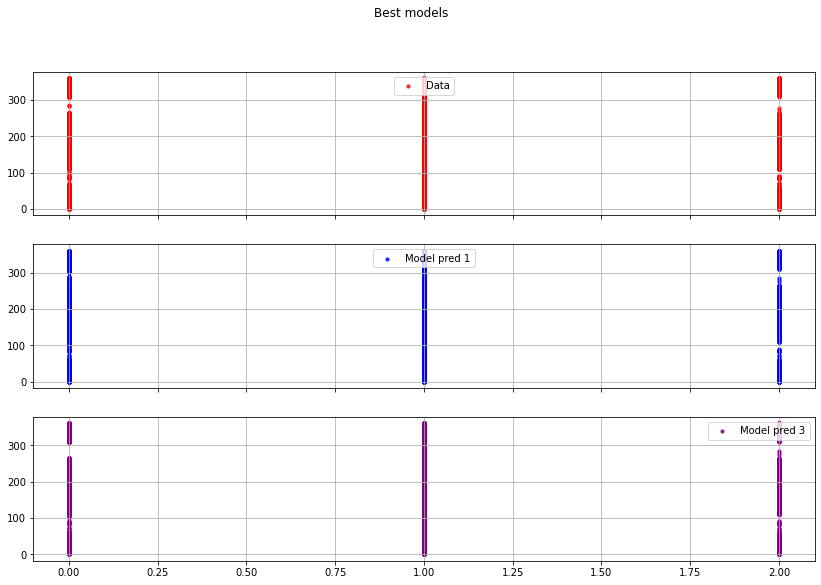

In [43]:
fig, axs = plt.subplots(3, figsize=(14,9), sharex="col")
fig.suptitle('Best models')

axs[0].scatter(np.argmax(Y, axis=1), X[:,0], s=1e1, alpha=0.8, c='red', label="Data")
# axs[0].set_yscale("log"); 
axs[0].grid(); axs[0].legend()

axs[1].scatter(Y_pred1, X[:,0], s=1e1, alpha=0.8, c='blue', label="Model pred 1")
# axs[1].set_yscale("log"); 
axs[1].grid(); axs[1].legend()

axs[2].scatter(Y_pred2, X[:,0], s=1e1, alpha=0.8, c='purple', label="Model pred 3")
# axs[2].set_yscale("log"); 
axs[2].grid(); axs[2].legend()

plt.show()

# axs[3].scatter(X[:,0], Y_pred3, s=1e1, alpha=0.8, c='green', label="Model pred 3")
# axs[3].set_yscale("log"); axs[3].grid(); axs[3].legend()

# for ax in axs.flat:
#     ax.set(xlabel=r'$k$', ylabel='$A(k,r,x)$')
# plt.show()

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(X[:,0], Y, s=5e1, alpha=0.8, c='red', label="Data")
# plt.scatter(X[:,0], Y_pred1, s=1e1, alpha=0.4, c='blue', label="Model pred 1")
plt.scatter(X[:,0], Y_pred3, s=1e1, alpha=0.4, c='green', label="Model pred 3")
plt.xlabel('$k$', fontsize=14); plt.ylabel(r'$A(k,r,x)$', fontsize=14)
plt.yscale('log'); plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(len(models), figsize=(14,9), sharex="col")
fig.suptitle('Data and model predictions')

axs[0].scatter(X[:,1], Y, s=1e1, alpha=0.8, c='red', label="Data")
axs[0].set_yscale("log"); axs[0].grid(); axs[0].legend()

axs[1].scatter(X[:,1], Y_pred1, s=1e1, alpha=0.8, c='blue', label="Model pred 1")
axs[1].set_yscale("log"); axs[1].grid(); axs[1].legend()

axs[2].scatter(X[:,1], Y_pred3, s=1e1, alpha=0.8, c='purple', label="Model pred 3")
axs[2].set_yscale("log"); axs[2].grid(); axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel=r'$r$', ylabel='$A(k,r,x)$')
plt.show()

In [ ]:
plt.figure(figsize=(14,7))
plt.scatter(X[:,1], Y, s=5e0, alpha=0.7, c='red', label="Data")
plt.scatter(X[:,1], Y_pred3, s=5e0, alpha=0.7, c='green', label="Model pred 3")
# plt.scatter(X[:,1], Y_pred2, s=5e0, alpha=0.7, c='blue', label="Model pred 2")
plt.xlabel('$r$', fontsize=14); plt.ylabel(r'$A(k,r,x)$', fontsize=14)
plt.yscale('log'); plt.legend(); plt.grid();
plt.show()

In [ ]:
fig, axs = plt.subplots(1,len(models), figsize=(14,5), sharey="row")
fig.suptitle('Data and model predictions')

axs[0].scatter(X[:,2], Y, s=1e0, alpha=0.8, c='red', label="Data")
axs[0].set_yscale("log"); axs[0].grid(); axs[0].legend()

axs[1].scatter(X[:,2], Y_pred1, s=1e0, alpha=0.8, c='blue', label="Model pred 1")
axs[1].set_yscale("log"); axs[1].grid(); axs[1].legend()

axs[2].scatter(X[:,2], Y_pred3, s=1e0, alpha=0.8, c='purple', label="Model pred 3")
axs[2].set_yscale("log"); axs[2].grid(); axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel=r'$x$', ylabel='$A(k,r,x)$')
plt.show()

### Comparación 3D

In [74]:
X[:,4].min(),X[:,4].max(), X[:,4].mean(), X[:,4].std()

(9.82207, 29.571859999999997, 19.645762146, 1.854750420523872)

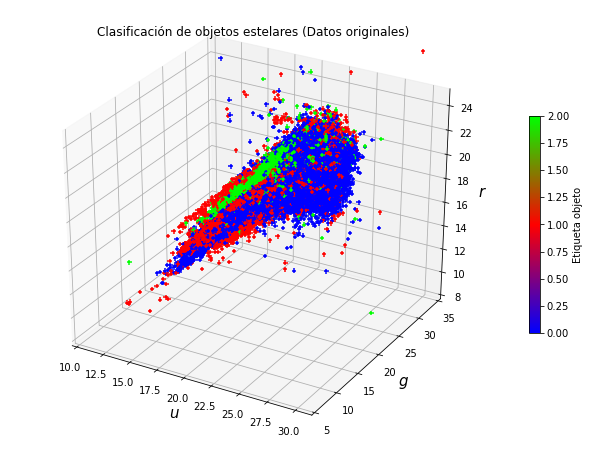

In [88]:
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,2], X[:,3], X[:,4], marker='+', c=np.argmax(Y,axis=1), cmap='brg', alpha=1)
ax.set_xlabel('$u$', fontsize=15); ax.set_xlim([10, 31])
ax.set_ylabel('$g$', fontsize=15); ax.set_ylim([5, 35])
ax.set_zlabel('$r$', fontsize=15); ax.set_zlim([8, 25])
plt.colorbar(p, shrink=0.5, label='Etiqueta objeto'); plt.title(r"Clasificación de objetos estelares (Datos originales)")
plt.show()

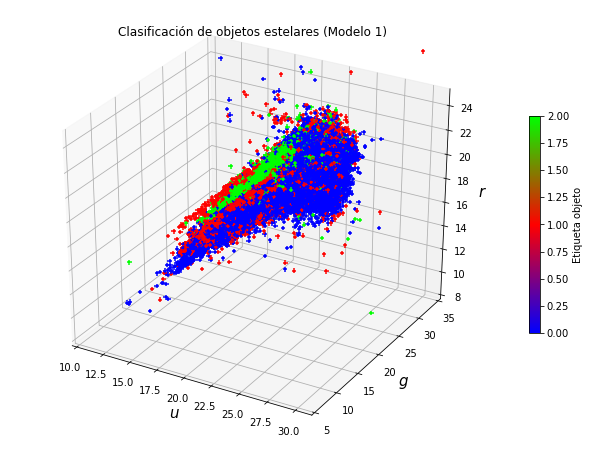

In [89]:
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,2], X[:,3], X[:,4], marker='+', c=Y_pred1, cmap='brg', alpha=1)
ax.set_xlabel('$u$', fontsize=15); ax.set_xlim([10, 31])
ax.set_ylabel('$g$', fontsize=15); ax.set_ylim([5, 35])
ax.set_zlabel('$r$', fontsize=15); ax.set_zlim([8, 25])
plt.colorbar(p, shrink=0.5, label='Etiqueta objeto'); plt.title(r"Clasificación de objetos estelares (Modelo 1)")
plt.show()

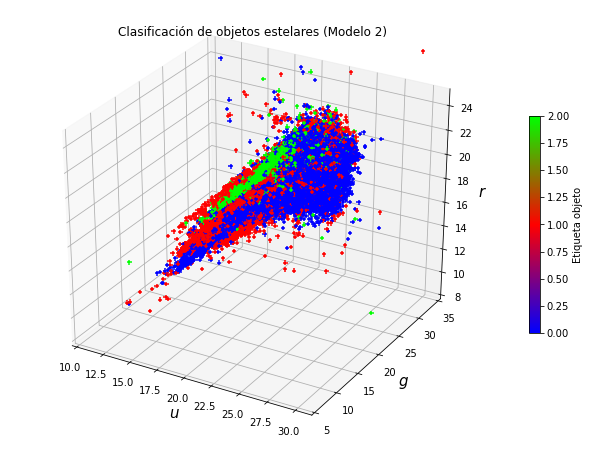

In [90]:
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,2], X[:,3], X[:,4], marker='+', c=Y_pred2, cmap='brg', alpha=1)
ax.set_xlabel('$u$', fontsize=15); ax.set_xlim([10, 31])
ax.set_ylabel('$g$', fontsize=15); ax.set_ylim([5, 35])
ax.set_zlabel('$r$', fontsize=15); ax.set_zlim([8, 25])
plt.colorbar(p, shrink=0.5, label='Etiqueta objeto'); plt.title(r"Clasificación de objetos estelares (Modelo 2)")
plt.show()

### Resultado de hiperparámetros

In [ ]:
import seaborn as sns

In [ ]:
df

In [ ]:
# Guarda las mejores N soluciones - (1, para k=1)
best_individuals2 = tools.selBest(population,k = 20)
deep_size2 = []
num_units2 = []
learning_rate2 = []
batch_size2 = []
epochs2 = []
t = 0

for bi in best_individuals2:
    deep_size_bits2 = BitArray(bi[0:2])
    num_units_bits2 = BitArray(bi[2:4])
    learning_rate_bits2 = BitArray(bi[4:7])
    batch_size_bits2 = BitArray(bi[7:9])
    epochs_bits2 = BitArray(bi[9:])
    t += 1 
    
    deep_size2.append( 4*(deep_size_bits2.uint + 1))
    num_units2.append( 4*(num_units_bits2.uint + 1))
    learning_rate2.append( 8*(learning_rate_bits2.uint+1)*10**(-4))
    batch_size2.append( 2**(batch_size_bits2.uint +1))
    epochs2.append( 50*(epochs_bits2.uint +1))
#     print('k=',t,'\nDeep Size: ', best_deep_size2[-1], ', Num of Units: ', best_num_units2[-1], ', Learning rate: ', best_learning_rate2[-1])
#     print('Batch Size: ', best_batch_size2[-1], ", Num of Epochs: ", best_epochs2[-1])

In [ ]:

best_genes.iloc[0]

In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(15,5))

# fig.suptitle('Última generación de hipermarámetros obtenidos')

# # axs[0].plot(df.iloc[:,0], df.iloc[:,1], alpha=0.5, c='blue', label="Model pred 1")
# axs[0].scatter(df.iloc[:,0], df.iloc[:,1], s=20, alpha=0.3, c='red', label="Model pred 1")
# axs[0].scatter(best_genes.iloc[:,0], best_genes.iloc[:,1], s=80, alpha=1, c='red', label="Mejores individuos")
# axs[0].grid(); axs[0].legend()
# # axs[0].legend(loc='upper right'); 
# # axs[0].set_xlim([2, 18]); axs[0].set_ylim([1, 65])
# axs[0].set(xlabel=r'Deep size', ylabel='Num units')

# # axs[1].plot(df.iloc[:,2], df.iloc[:,3], alpha=0.5, c='blue', label="Model pred 1")
# axs[1].scatter(df.iloc[:,2], df.iloc[:,3], s=20, alpha=0.3, c='red', label="Model pred 1")
# axs[1].scatter(best_genes.iloc[:,2], best_genes.iloc[:,3], s=80, alpha=1, c='red', label="Mejores individuos")
# axs[1].set_yscale("log"); 
# axs[1].grid(); axs[1].legend(loc='upper right')
# # axs[1].set_xlim([1e-4, 31e-4]); axs[1].set_ylim([2**1, 2**4])
# axs[1].set(xlabel=r'Learning rate', ylabel='Batch size')

In [ ]:
g1= sns.jointplot(data=df, x="Deep size", y="Num units", kind="kde")
g1.ax_joint.scatter(best_genes.iloc[:,0], best_genes.iloc[:,1], color = 'red', label="a")

plt.show()

g2= sns.jointplot(x=df.iloc[:,2], y=df.iloc[:,3], kind='kde')
g2.ax_joint.scatter(best_genes.iloc[:,2], best_genes.iloc[:,3], color = 'red', label="a")

plt.show()